## Resolution test 
This notebook aims to do the image processing for analyzing the optical resolution.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

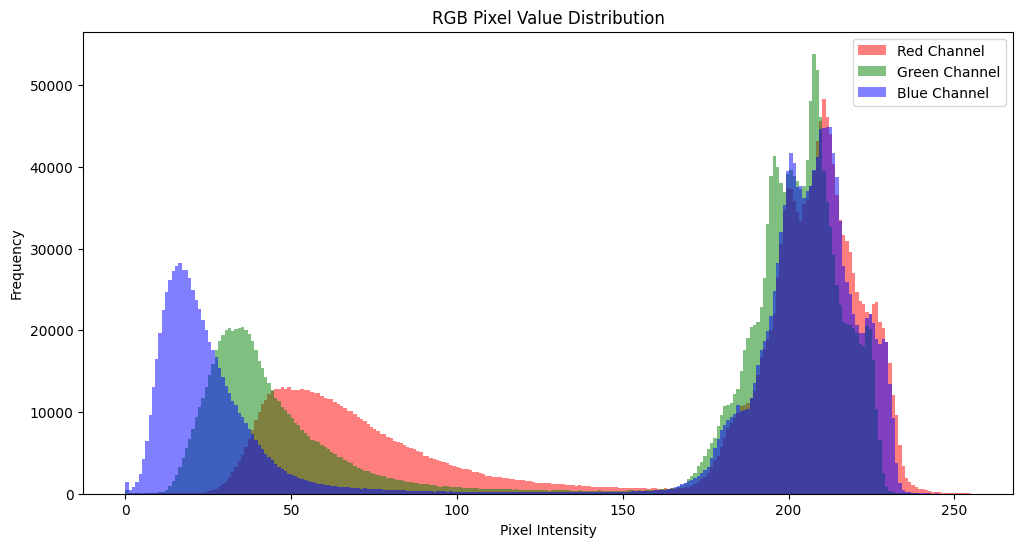

In [52]:


# Load the image
image_path = 'Figures/tomato_edge.jpg'
#image_path = 'Figures/1mm rule.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Get RGB distribution
def plot_rgb_distribution(image_rgb):
    r_values, g_values, b_values = image_rgb[:, :, 0], image_rgb[:, :, 1], image_rgb[:, :, 2]
    plt.figure(figsize=(12, 6))
    plt.hist(r_values.ravel(), bins=256, color='red', alpha=0.5, label='Red Channel')
    plt.hist(g_values.ravel(), bins=256, color='green', alpha=0.5, label='Green Channel')
    plt.hist(b_values.ravel(), bins=256, color='blue', alpha=0.5, label='Blue Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('RGB Pixel Value Distribution')
    plt.show()

plot_rgb_distribution(image_rgb)


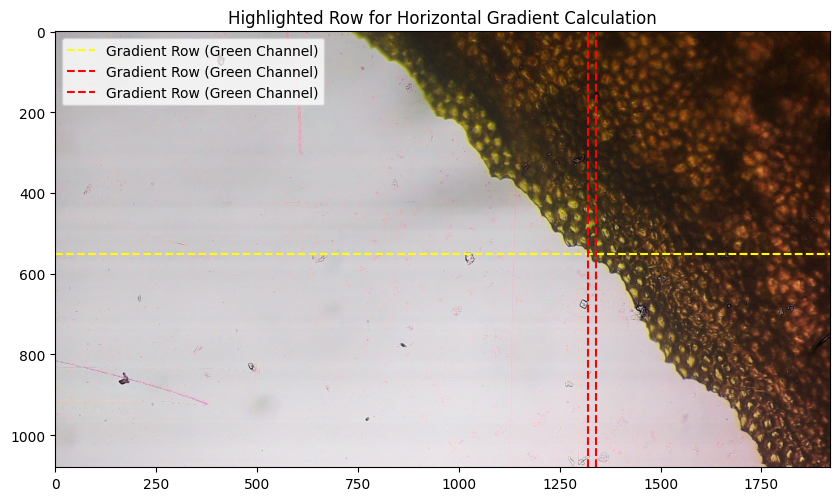

In [58]:
# Horizontal derivative
# Select a horizontal line (row) in the middle of the image
row = image_rgb.shape[0] // 2 +10
column = image_rgb.shape[1] *3// 4 -110
width = 10
line_rgb = image_rgb[row, column-width:column+width, :]

plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.axhline(row, color='yellow', linestyle='--', linewidth=1.5, label='Gradient Row (Green Channel)')
plt.axvline(column-width, color='red', linestyle='--', linewidth=1.5, label='Gradient Row (Green Channel)')
plt.axvline(column+width, color='red', linestyle='--', linewidth=1.5, label='Gradient Row (Green Channel)')
plt.legend()
plt.title('Highlighted Row for Horizontal Gradient Calculation')
plt.show()


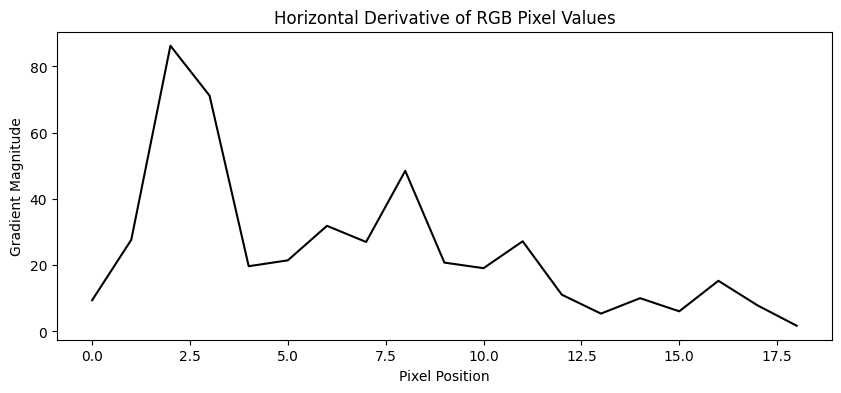

FWHM of the horizontal derivative: 3 pixels 4.190e-06 mm


In [59]:


# Compute the derivative across the line
derivative = np.diff(line_rgb.astype(float), axis=0)

# Calculate the magnitude of the gradient
gradient_magnitude = np.linalg.norm(derivative, axis=1)

# Plot the horizontal derivative
plt.figure(figsize=(10, 4))
plt.plot(gradient_magnitude, color='black')
plt.xlabel('Pixel Position')
plt.ylabel('Gradient Magnitude')
plt.title('Horizontal Derivative of RGB Pixel Values')
plt.show()

# Calculate FWHM
half_max = np.max(gradient_magnitude) / 2
peaks, _ = find_peaks(gradient_magnitude, height=half_max)

peak_idx = np.argmax(gradient_magnitude)
peak_value = gradient_magnitude[peak_idx]
half_max = peak_value / 2

left_idx = np.where(gradient_magnitude[:peak_idx] <= half_max)[0][-1]
right_idx = peak_idx + np.where(gradient_magnitude[peak_idx:] <= half_max)[0][0]
fwhm = right_idx- left_idx

print(f'FWHM of the horizontal derivative: {fwhm} pixels {fwhm/716*1e-3:.3e} mm')


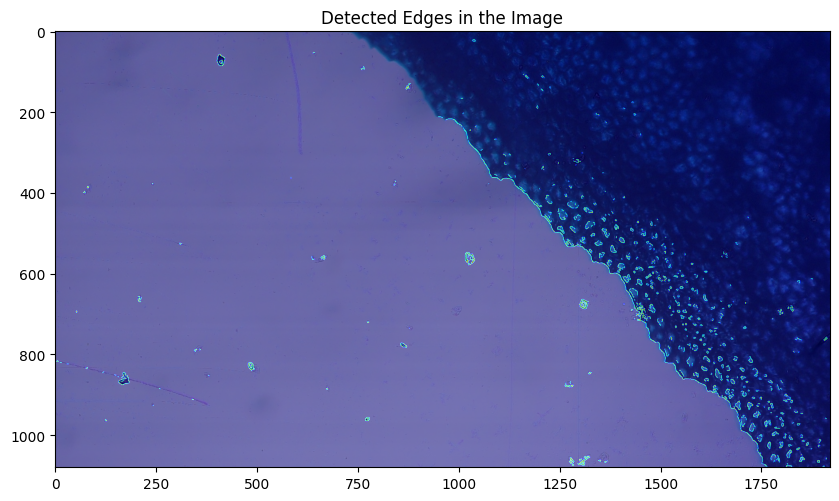

Number of edge points detected: 10400
Example edge positions (x, y):
[[  21 1035]
 [  21 1036]
 [  21 1037]
 [  21 1038]
 [  21 1039]
 [  22 1034]
 [  22 1035]
 [  22 1039]
 [  22 1040]
 [  22 1041]]


In [62]:

image = cv2.imread(image_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(image_gray, (3, 3), 0)

# Use the Canny edge detector
edges = cv2.Canny(blurred_image, threshold1=200, threshold2=250)

# Find the positions of edges
edge_positions = np.column_stack(np.where(edges > 0))

# Display the edges on the image
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')
plt.imshow(edges, cmap='jet', alpha=0.5)  # Overlay edges with color
plt.title('Detected Edges in the Image')
plt.show()

# Output the edge positions
print(f"Number of edge points detected: {len(edge_positions)}")
print("Example edge positions (x, y):")
print(edge_positions[:10])  # Display first 10 edge points

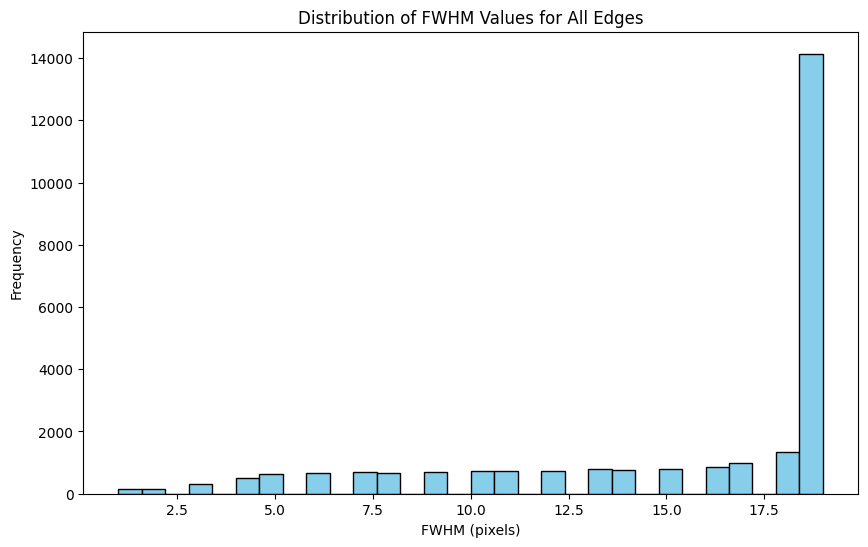

Average FWHM: 15.46 pixels
Median FWHM: 19.00 pixels
Standard Deviation of FWHM: 5.00 pixels


In [61]:
import cv2
import numpy as np
from scipy.signal import find_peaks

# Load the image
image_path = 'Figures/tomato_edge.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to reduce noise
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Use Canny edge detection to find edges
edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)

# Find coordinates of edge pixels
edge_positions = np.column_stack(np.where(edges > 0))

# Initialize a list to store FWHM values
fwhm_values = []

# Define a function to calculate FWHM for an edge intensity profile
def calculate_fwhm(profile):
    peak_value = np.max(profile)
    half_max = peak_value / 2
    
    # Find positions where profile crosses half maximum
    half_max_positions = np.where(profile >= half_max)[0]
    if len(half_max_positions) > 1:
        fwhm = half_max_positions[-1] - half_max_positions[0]
        return fwhm
    return None

# Loop through edge positions to calculate FWHM for each edge
for (y, x) in edge_positions:
    # Take intensity profile perpendicular to the edge
    if x + 10 < image.shape[1]:  # Ensure we don't go out of bounds
        profile = image[y, x:x+20]
        fwhm = calculate_fwhm(profile)
        if fwhm is not None:
            fwhm_values.append(fwhm)

plt.figure(figsize=(10, 6))
plt.hist(fwhm_values, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('FWHM (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of FWHM Values for All Edges')
plt.show()

# Print some statistics about the FWHM distribution
average_fwhm = np.mean(fwhm_values)
median_fwhm = np.median(fwhm_values)
std_fwhm = np.std(fwhm_values)

print(f'Average FWHM: {average_fwhm:.2f} pixels')
print(f'Median FWHM: {median_fwhm:.2f} pixels')
print(f'Standard Deviation of FWHM: {std_fwhm:.2f} pixels')
